# Compute the condition number given the data, as well as the theoretical one

In [2]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [3]:
import jax
import mrcfile
from jax.scipy.special import gammaln
from jax import random
from tqdm import tqdm 
from jaxopt import LBFGS

import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.algorithm import sgd, get_sgd_vol_ops, get_cg_vol_ops, oasis
from src.algorithm import conjugate_gradient as cg
from src.datasets import *
from src.noise import estimate_noise, average_radially, estimate_noise_radial
from src.preprocess import *
from src.fsc import calc_fsc

plt.rcParams["figure.figsize"]=6,6

### Loading the files, basic preprocessing etc. Identical to the main Higher_stochastic notebook

In [4]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles: 105519
load_data: data loaded, time:  76.59 sec.


In [5]:
# Extract a subset with fixed seed key so that we always get the same subset.
# Larger sets must be supersets of the smaller sets respectively.

N0 = imgs0.shape[0]
nx0 = imgs0.shape[1]

subset_seed = 60
subset_key = random.PRNGKey(subset_seed)
idx_full = random.permutation(subset_key, N0)

print(subset_key)
print(idx_full[:10])

[ 0 60]
[ 18720  60093  53249 102196  43608  18973  24325  65695  39526  50914]


In [6]:
out_dir = out_dir = '../data/out_dev/'

nx_crop = 192 #64 #8 #192 # 128 # 64
N = 50000 #10000 #200 #104000 #80000 # 20000

idx = idx_full[:N]

In [7]:
processed_data = preprocess(imgs0, params0, nx_crop = nx_crop, idx = idx)

imgs_f = processed_data["imgs_f"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]

imgs0.shape = (105519, 320, 320)
pixel_size0.shape = (105519,)
angles0.shape = (105519, 3)
shifts0.shape = (105519, 2)
ctf_params0.shape = (105519, 9)
N0 = 105519
idx provided
N = 50000
Taking FFT of the images:
Batch 1/10  13.26 sec.
Batch 2/10  13.17 sec.
Batch 3/10  13.14 sec.
Batch 4/10  13.16 sec.
Batch 5/10  13.14 sec.
Batch 6/10  13.13 sec.
Batch 7/10  13.14 sec.
Batch 8/10  13.41 sec.
Batch 9/10  14.44 sec.
Batch 10/10  13.09 sec.
FFT done. Time:  165.58 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 1.92000000e+02]
Vectorised imgs_f.shape = (50000, 36864)
Mask radius = 0.22662213740458012
Noise free, setting sigma_noise = 1


In [8]:
# Assuming these variables are the same for all images

pixel_size = processed_data["pixel_size"]
nx = processed_data["nx"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
x_grid = processed_data["x_grid"]
N = imgs_f.shape[0]

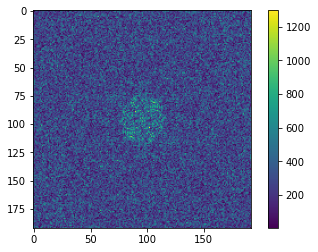

In [9]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[15].reshape([nx_crop,nx_crop]))));plt.colorbar()

In [10]:
del(imgs0)

In [11]:
# Apply mask to images

apply_mask = True

if apply_mask:
    #mask2d = mask[0].reshape(-1)
    mask2d = mask[0].reshape(-1)
    imgs_f = imgs_f * mask2d
else:
    mask = jnp.ones(mask.shape)

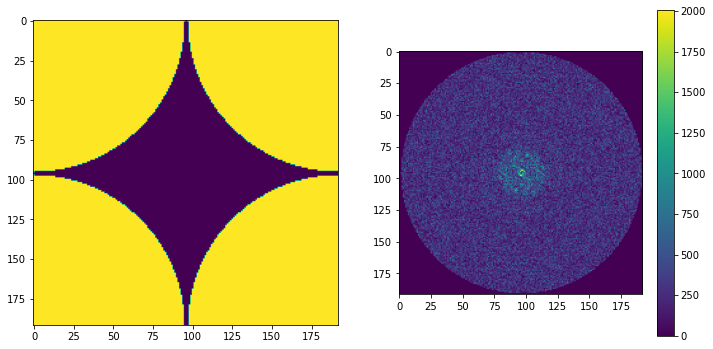

In [12]:
plt.rcParams["figure.figsize"]=12,6

plt.subplot(1,2,1)
plt.imshow(mask[0])

plt.subplot(1,2,2)
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[123].reshape([nx_crop,nx_crop]))));plt.colorbar()

plt.rcParams["figure.figsize"]=6,6

In [13]:
ctf_params.shape

(50000, 9)

In [14]:
ctf_params0 = jnp.array(N * [None])

In [15]:
alpha =  1e-8 #1e-9 #1e-5 #1e-9 #1e-9 # 1e-5
interp_method = "nn"

#slice_obj = Slice(x_grid, mask = mask, interp_method = interp_method)

slice_obj = Slice(x_grid, mask = mask, interp_method = interp_method)
loss_obj = Loss(slice_obj, alpha = alpha)
gradv_obj = GradV(loss_obj)

grad_func, loss_func, hvp_func, loss_px_func = get_sgd_vol_ops(gradv_obj, loss_obj, angles, shifts, ctf_params0, imgs_f, sigma_noise)


### Compute the condition number

In [17]:
# Compute the Hessian diagonals exactly (valid for NN interpolation) -
# In batches
# Full diagonal

compute_hess_diag = True

key = random.PRNGKey(62)
key, subkey = random.split(key)
x0 = random.normal(subkey, [nx,nx,nx], dtype=jnp.complex128)

if compute_hess_diag:
    batch_sz = 100
    n_batch = N // batch_sz
    idx_batches = np.array_split(np.arange(N), n_batch)
    ones = jnp.ones(x0.shape, dtype=jnp.complex128)

    D = np.zeros([nx,nx,nx], dtype=np.complex128)
    for idx in tqdm(idx_batches):
        D += hvp_func(x0, ones, idx)

    D = jnp.array(D/n_batch)
    
assert jnp.max(jnp.abs(jnp.imag(D))) < 1e-16
D = jnp.real(D)

100%|██████████| 500/500 [00:33<00:00, 14.78it/s]


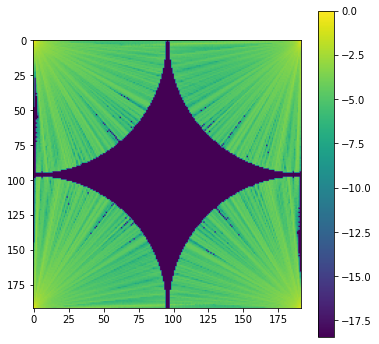

In [18]:
plt.imshow(jnp.log(D[0])) ; plt.colorbar()

In [19]:
jnp.max(D)/jnp.min(D)

DeviceArray(1.00000001e+08, dtype=float64)

In [20]:
1/alpha

100000000.0

In [21]:
R_max = jnp.prod(x_grid)/2

In [22]:
n_pts = 100
R_range = jnp.linspace(0, R_max, n_pts)

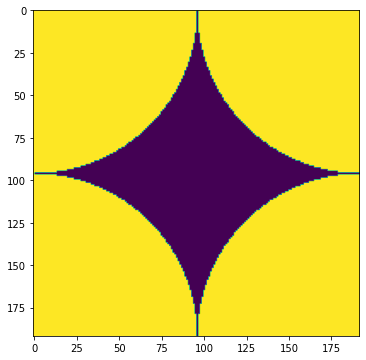

In [23]:
plt.imshow(create_3d_mask(x_grid,[0,0,0], R_range[-1])[0])

In [24]:
cond = []
D_maxs = []
D_mins = []

for r in tqdm(R_range[1:30]):
    mask_3d = create_3d_mask(x_grid, [0,0,0], r)
    D_masked = D*mask_3d
    D_max = jnp.max(D_masked)
    D_min = jnp.min(D_masked[D_masked > 0])
    
    D_maxs.append(D_max)
    D_mins.append(D_min)
    cond.append(D_max/D_min)

100%|██████████| 29/29 [00:42<00:00,  1.46s/it]


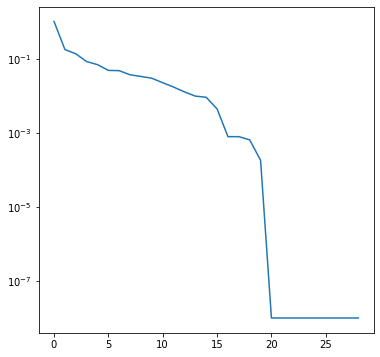

In [25]:
plt.semilogy(D_mins)

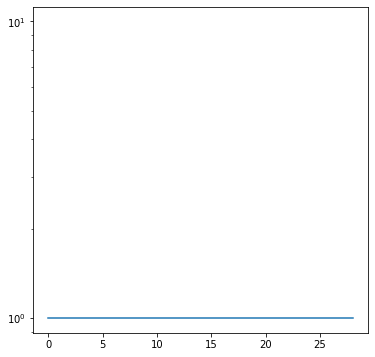

In [26]:
plt.semilogy(D_maxs)

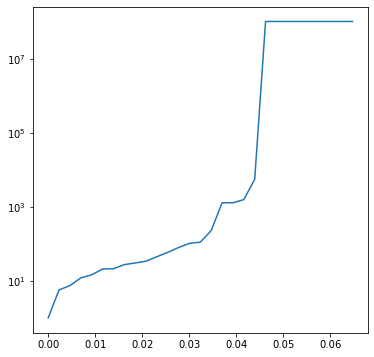

In [27]:
plt.semilogy(R_range[:len(cond)], cond)

In [28]:
print("R_min = ", R_range[1])
print("R_max = ", R_range[len(cond)])
new_R_range = R_range[1:len(cond)]

R_min =  0.002313208420078649
R_max =  0.06708304418228082


### Histogram of angles in the dataset

In [29]:
n_bins = 10

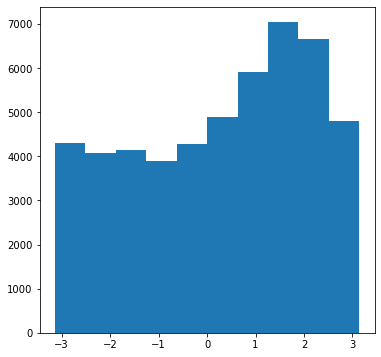

In [30]:
counts, bins = np.histogram(angles[:,0], bins=n_bins)
_ = plt.hist(bins[:-1], bins, weights=counts)

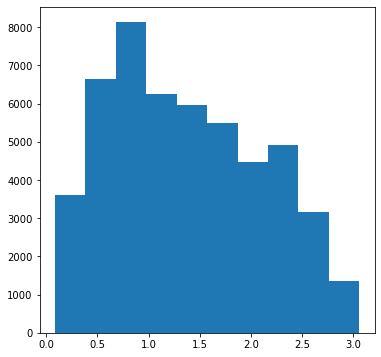

In [31]:
counts, bins = np.histogram(angles[:,1], bins=n_bins)
_ = plt.hist(bins[:-1], bins, weights=counts)

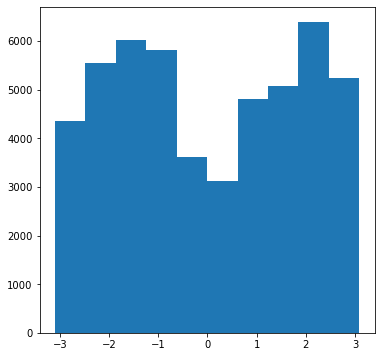

In [32]:
counts, bins = np.histogram(angles[:,2], bins=n_bins)
_ = plt.hist(bins[:-1], bins, weights=counts)

### Analytical condition number 

In [49]:
# Compute number of points in a disk/ball of a given radius. 
# The code is similar to the one in the src.fsc.average_shells and src.fsc.average_shells_2d functions
# but counts the points in the full 2D disk/3D ball rather than thin shells.

def compute_n_pts_2d(grid, dr):
    nx = int(grid[1])
    img = np.zeros((nx, nx))

    # Calculate the radius in the Fourier domain.
    x_freq = np.fft.fftfreq(int(grid[1]), 1/(grid[0]*grid[1]))
    X, Y = np.meshgrid(x_freq, x_freq)
    r = np.sqrt(X**2 + Y**2)

    # Max radius so that the shells are not outside the
    # rectangular domain.
    max_rad = np.max(r[:,0])

    # Calculate the shells.
    shell_n_pts = []
    res = []
    R = -dr/2
    while R + dr <= max_rad:
        cond = (r < R + dr)
        shell_n_pts.append(np.sum(cond))
        res.append(R)
        R += dr
    res[0] = 0

    res = np.array(res)
    shell_n_pts = np.array(shell_n_pts)

    return res, shell_n_pts

def compute_n_pts_3d(grid, dr):
    nx = int(grid[1])
    v = np.zeros((nx, nx, nx))

    # Calculate the radius in the Fourier domain.
    x_freq = np.fft.fftfreq(int(grid[1]), 1/(grid[0]*grid[1]))
    X, Y, Z = np.meshgrid(x_freq, x_freq, x_freq)
    r = np.sqrt(X**2 + Y**2 + Z**2)

    # Max radius so that the shells are not outside the
    # rectangular domain.
    max_rad = np.max(r[:,0,0])

    # Calculate the shells.
    shell_n_pts = []
    res = []
    R = -dr/2
    while R + dr <= max_rad:
        cond = (r < R + dr)
        shell_n_pts.append(np.sum(cond))
        res.append(R)
        R += dr
    res[0] = 0

    res = np.array(res)
    shell_n_pts = np.array(shell_n_pts)

    return res, shell_n_pts

(171,)


<ipython-input-114-99534b589106>:17: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(1/res)


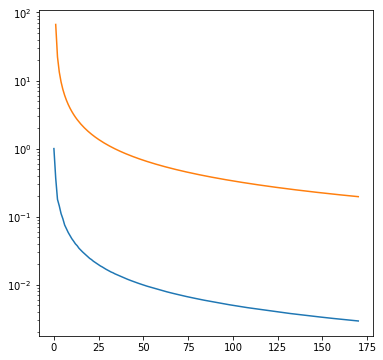

In [114]:
#dr = 0.00231321
dr_grid = 0.02
n_grid = 512
dr = 0.03

# With a bigger grid
res, pts_2d = compute_n_pts_2d([dr_grid, n_grid], dr)
res2, pts_3d = compute_n_pts_3d([dr_grid, n_grid], dr)

p = pts_2d/pts_3d

assert jnp.max(jnp.abs(res-res2)) == 0, "Use the same step size dr in the calculations above!!!"

print(res.shape)

plt.semilogy(p)
plt.semilogy(1/res)

In [115]:
@jax.jit
def calc_kappa_term(l, p, N, alpha):
    return ((1+alpha)/(l/N + alpha) - 1) * p**l * (1-p)**(N-l)

In [168]:
Ms = [10,100,500,1000, 5000] #N
kappas = np.zeros([len(Ms), len(res)])

#r = res[1:] 
#rr = jnp.linspace(2, 100000, 40)

pp = p #p[1:31]
#pp = jnp.linspace(0.6, 0.0001)
#pp2 = 1/new_R_range
#for pp in tqdm(p[1:]):
#pp = 1/rr

for iM, M in enumerate(Ms):
    print(f"M = {M}")
    for i, pi in tqdm(enumerate(pp)):
        kappa_terms = jax.vmap(calc_kappa_term, in_axes = (0, None, None, None))(jnp.arange(M), pi, M, alpha)
        kappa = 1 + jnp.sum(kappa_terms)
        kappas[iM, i] = kappa

kappas = jnp.array(kappas)

M = 10


171it [00:00, 742.92it/s]


M = 100


171it [00:00, 716.40it/s]


M = 500


171it [00:00, 714.90it/s]


M = 1000


171it [00:00, 712.82it/s]


M = 5000


171it [00:00, 727.25it/s]


In [169]:
tick_vals = [f"{p[i]:0.0e}" for i in range(len(p))]
print(tick_vals[:10])

['1e+00', '4e-01', '2e-01', '1e-01', '1e-01', '9e-02', '8e-02', '7e-02', '6e-02', '5e-02']


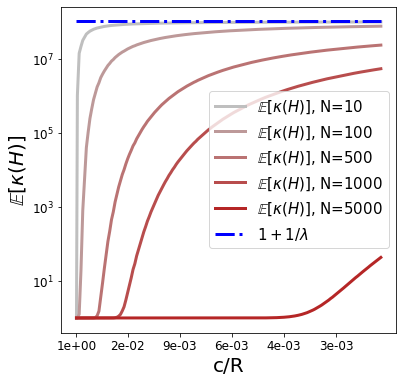

In [209]:
# The actual plot for the paper

crange_color = np.linspace(0.75, 0.7, len(Ms)+1)
crange_other = np.linspace(0.75, 0.0, len(Ms)+1)

lgd = []
for i in range(len(Ms)):
    c = (crange_color[i], crange_other[i], crange_other[i])
    plt.semilogy(res, kappas[i], linewidth=3, color=c)
    lgd.append("$\mathbb{E}[\kappa(H)]$," + f" N={Ms[i]}")
    
plt.semilogy(res, (1+1/alpha)*np.ones(res.shape), 'b-.', linewidth=3)
lgd.append("$1 + 1/\lambda$")

plt.xticks(res,tick_vals, fontsize='12')
plt.yticks(fontsize='12')
plt.locator_params(axis='x', nbins=6)
plt.xlabel("c/R",fontsize='20')
plt.ylabel("$\mathbb{E}[\kappa(H)]$", fontsize='20')
plt.legend(lgd, fontsize='15')

Rel error =  1.4916614839266227e-07


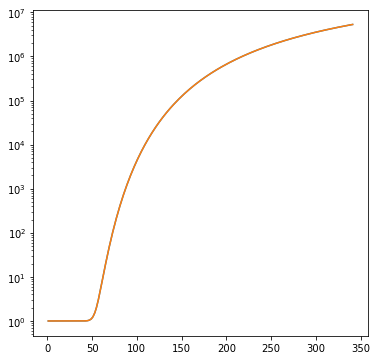

In [132]:
# Compute the lower bound, looks tight enough.

kappas_bound = jnp.array(1 + 1/alpha * (1-pp)**M)

plt.semilogy(1/pp, kappas)
plt.semilogy(1/pp, kappas_bound)

# Relative error between the condition number and the lower bound

print("Rel error = ", jnp.max(jnp.abs(kappas-kappas_bound)/jnp.abs(kappas)))